## 7.2 나이브베이즈 분류모형

In [1]:
# 현실적으로 텍스트 데이터에서 굉장히 많이 쓴다.
# 텍스트 데이터는 피처의 개수, X의 종류가 굉장히 많다.
# BOW 방법을 쓰게되면 안에 들어 있는 단어, n-gram을 쓰게 되면 구문 구절의 개수 만큼 키워드(토큰)가 생긴다.
# 그 토큰의 개수가 바로 피처의 개수가 된다.
# 피처의 개수가 수만개에서 수십만개, 이렇게 피처가 많게 되면 로지스틱 회귀나, QDA, LDA는 계산량이 부족해서 못 쓰게 된다
# QDA, LDA 쓰기 위해 시그마 계산해야 하는데 시그마가 10만개의 제곱개(100억개)의 숫자를 추정해야 한다
# 그렇게 해서 추정해낸 값이 실제로 거의 쓸모없는 값이 나옴
# 랜덤 매트릭스 이론에서 나오는 얘기. 데이터는 수천개밖에 안 되는데 거기에서 수백억개 갖다가 강제로 뽑아내면 노이즈가 실리게 된다
# 그래서 추정 결과로 쓸모없는 쓰레기 데이터가 나온다.

In [3]:
# 나이브 베이즈 분류모형은 앞에서 나온 QDA에 조건부 독립이라는 가정을 하게 된다
# C가 주어졌을 때만 독립이 되는 것을 조건부독립이라고 한다

### 조건부독립

확률변수 A, B가 독립이면 A, B의 결합확률은 주변확률의 곱과 같다.

$$ P(A, B) = P(A)P(B) $$

조건부독립(conditional independence)은 일반적인 독립과 달리 조건이 되는 별개의 확률변수 C가 존재해야 한다.
조건이 되는 확률변수 C에 대한 A, B의 결합조건부확률이 C에 대한 A, B의 조건부확률의 곱과 같으면 A와 B가 C에 대해 조건부독립이라고 한다.

$$ P(A, B|C) = P(A|C) P(B|C) $$

기호로는 다음과 같이 표기한다.

$$ A \text{⫫} B \;\vert\; C $$

조건부독립과 비교하여 일반적인 독립은 무조건부독립이라고 한다. 무조건부독립은 다음과 같이 표기하도 한다.

$$ A \text{⫫} B \;\vert\; \emptyset $$

A, B가 C에 대해 조건부독립이면 다음도 만족한다.

$$ P(A|B,C) = P(A|C) $$

$$ P(B|A,C) = P(B|C) $$

주의할 점은 조건부독립과 무조건부독립은 관계가 없다는 점이다. 즉, 두 확률변수가 독립이라고 항상 조건부독립이 되는 것도 아니고 조건부독립이라고 꼭 독립이 되는 것도 아니다.

$$ P(A,B) = P(A)P(B) \;\; \bcancel{\implies} \;\; P(A,B|C) = P(A|C)P(B|C) $$

$$  P(A,B|C) = P(A|C)P(B|C) \;\; \bcancel{\implies} \;\; P(A,B) = P(A)P(B) $$

In [4]:
# 조건부독립의 성질은 후에 확률적 그래프 모델에서 많이 쓰인다.
# 조건부독립과 무조건부독립은 아무 관계가 없다.

예를 들어 어떤 동물의 어미의 몸무게가 $x$kg일 때 새끼의 몸무게는 $x$를 기댓값으로 하고 5kg 표준편차를 가지는 정규분포라고 가정하자. 이 동물의 새끼 중 2마리의 몸무게를 각각 A, B라고 하고 어미의 몸무게를 C라고 한다. 시물레이션을 통해 어미 표본과 각각의 어미에 대해 2마리의 새끼 표본을 만들자.

In [6]:
np.random.seed(0)
C = np.random.normal(100, 15, 2000)
A = C + np.random.normal(0, 5, 2000)
B = C + np.random.normal(0, 5, 2000)

스캐터플롯을 보면 A와 B 자체는 상관관계가 있음을 알 수 있다. 하지만 어미의 몸무게가 고정되어 있으면 두 새끼의 몸무게는 서로 독립인 것을 볼 수 있다.

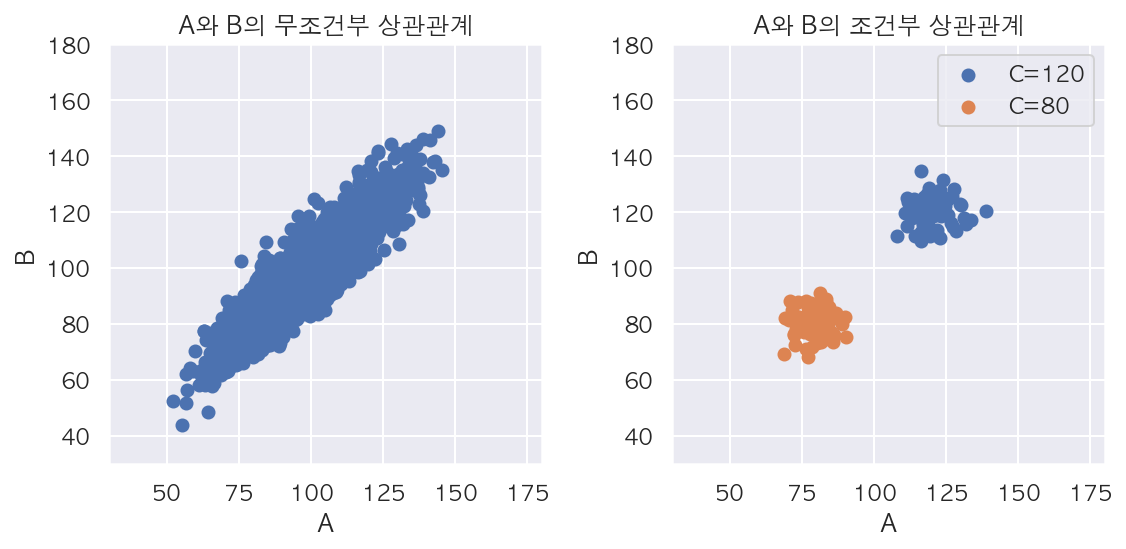

In [11]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.scatter(A, B)
plt.xlabel("A")
plt.ylabel("B")
plt.xlim(30, 180)
plt.ylim(30, 180)
plt.title("A와 B의 무조건부 상관관계")

plt.subplot(122)
idx1 = (118 < C) & (C < 122)
idx2 = (78 < C) & (C < 82)
plt.scatter(A[idx1], B[idx1], label="C=120")
plt.scatter(A[idx2], B[idx2], label="C=80")
plt.xlabel("A")
plt.ylabel("B")
plt.xlim(30, 180)
plt.ylim(30, 180)
plt.legend()
plt.title("A와 B의 조건부 상관관계")

plt.tight_layout()
plt.show()

In [1]:
# 조건부 독립(원래는 상관관계 있는 것들이 조건이 주어지면 서로 독립이 된다)
# 어미 돼지가 무거우면 새끼1과 새끼2도 비슷하게 무겁다.
# 새끼1이 무거우면 새끼2도 무겁겠다고 유추가능하다(서로 상관관계가 있다)
# 자식 새끼들은 어미의 몸무게가 밝혀지면 조건부독립이 된다
# 같은 어미라는 것을 빼면 서로 상관관계가 있다. 형이 크면 동생도 크다.
# 어미가 같은 어미라고 못박아버리면 형이 큰 것과 동생이 큰 것은 아무런 상관관계가 없다

### 나이브 가정

In [16]:
# 모든 차원의 개별 독립변수가 서로 조건부독립이라는 가정
# 독립변수 x가 범주값으로 다차원일 때 차원이 커지면 커질수록 계산이 현실적으로 어려워진다?
# 나이브베이즈 분류모형에서는 모든 차원의 개별 독립변수가 서로 조건부독립이라는 가정을 사용

독립변수 $x$가 $D$차원이라고 가정하자. 

$$ x = (x_1, \ldots, x_D) $$

가능도함수는 $x_1, \ldots, x_D$의 결합확률이 된다.

$$ P(x \mid y = k) = P(x_1, \ldots, x_D \mid y = k) $$ 

원리상으로는 $y=k$인 데이터만 모아서 이 가능도함수의 모양을 추정할 수 있다. 하지만 차원 $D$가 커지면 가능도함수의 추정이 현실적으로 어려워진다. 

따라서 나이즈베이즈 분류모형(Naive Bayes classification model)에서는 모든 차원의 개별 독립변수가 서로 조건부독립(conditional independent)이라는 가정을 사용한다. 이러한 가정을 나이브 가정(naive assumption)이라고 한다.



나이브 가정으로 사용하면 벡터 $x$의 결합확률분포함수는 개별 스칼라 원소 $x_d$의 확률분포함수의 곱이 된다.

$$
P(x_1, \ldots, x_D \mid y = k) = \prod_{d=1}^D P(x_d \mid y = k)
$$

스칼라 원소 $x_d$의 확률분포함수는 결합확률분포함수보다 추정하기 훨씬 쉽다.

가능도함수를 추정한 후에는 베이즈정리를 사용하여 조건부확률을 계산할 수 있다.

$$
\begin{align}
P(y = k \mid x) 
&= \dfrac{ P(x_1, \ldots, x_D \mid y = k) P(y = k) }{P(x)} \\
&= \dfrac{ \left( \prod_{d=1}^D P(x_{d} \mid y = k) \right) P(y = k) }{P(x)}
\end{align}
$$


In [13]:
# 위의 공식은 나이브 베이즈 분류 모형의 수식

### 정규분포 가능도 모형

$x$ 벡터의 원소가 모두 실수이고 클래스마다 특정한 값 주변에서 발생한다고 하면 가능도 분포로 정규분포를 사용한다.
각 독립변수 $x_d$마다, 그리고 클래스 $k$마다 정규 분포의 기댓값 $\mu_{d,k}$, 표준 편차 $\sigma_{d,k}^2$가 달라진다. QDA 모형과는 달리 모든 독립변수들이 서로 조건부독립이라고 가정한다.

$$ P(x_d \mid y = k) = \dfrac{1}{\sqrt{2\pi\sigma_{d,k}^2}} \exp \left(-\dfrac{(x_d-\mu_{d,k})^2}{2\sigma_{d,k}^2}\right) $$
  

### 베르누이분포 가능도 모형

베르누이분포 가능도 모형에서는 각각의 $x = (x_1,\ldots, x_D)$의 각 원소 $x_d$가 0 또는 1이라는 값만을 가질 수 있다. 즉 독립변수는 $D$개의 독립(조건부독립)적인 베르누이 확률변수, 즉 동전으로 구성된 동전 세트로 표현할 수 있다. 이 동전들의 모수 $\mu_{d}$는 동전 $d$마다 다르다.

그런데 클래스 $y = k$ $(k=1,\ldots,K)$마다도 $x_d$가 1이 될 확률이 다르다. 즉, 동전의 모수 $\mu_{d,k}$는 동전 $d$마다 다르고 클래스 $k$마다도 다르다. 즉, 전체 $D \times K$의 동전이 존재하며 같은 클래스에 속하는 $D$개의 동전이 하나의 동전 세트를 구성하고 이러한 동전 세트가 $K$개 있다고 생각할 수 있다.

$$ P(x_d \mid y = k) = \mu_{d,k}^{x_d} (1-\mu_{d,k})^{(1-x_d)} $$

$$ 
P(x_1, \ldots, x_D \mid y = k) 
= \prod_{d=1}^D \mu_{d,k}^{x_d} (1-\mu_{d,k})^{(1-x_d)}
$$

이러한 동전 세트마다 확률 특성이 다르므로 베르누이분포 가능도 모형을 기반으로 하는 나이브베이즈 모형은 동전 세트를 $N$번 던진 결과로부터 $1,\ldots,K$ 중 어느 동전 세트를 던졌는지를 찾아내는 모형이라고 할 수 있다.

### 다항분포 가능도 모형

다항분포 모형에서는 $x$ 벡터가 다항분포의 표본이라고 가정한다. 즉, $D$개의 면을 가지는 주사위를 $\sum_{d=1}^D x_d$번 던져서 나온 결과로 본다.
예를 들어 $x$가 다음과 같다면,

$$ x = (1, 4, 0, 5) $$

4면체 주사위를 10번 던져서 1인 면이 1번, 2인 면이 4번, 4인 면이 5번 나온 결과로 해석한다.

각 클래스마다 주사위가 다르다고 가정하므로 $K$개의 클래스를 구분하는 문제에서는 $D$개의 면을 가진 주사위가  $K$개 있다고 본다. 

$$ 
P(x_1, \ldots, x_D \mid y = k) 
\;\; \propto \;\; \prod_{d=1}^D \mu_{d,k}^{x_{d,k}} 
$$

$$ \sum_{d=1}^{D} \mu_{d,k} = 1 $$

따라서 다항분포 가능도 모형을 기반으로 하는 나이브베이즈 모형은 주사위를 던진 결과로부터  $1,\ldots,K$ 중 어느 주사위를 던졌는지를 찾아내는 모형이라고 할 수 있다.

In [15]:
# 정확히 말하면 독립이 아니다. 전체 개수의 합이 N으로 똑같아야 한다
# 하다보니까 결합함수가 독립인것처럼 곱으로 뭉쳐 있어서 나이브 베이즈 모델 안에 끼워 넣은 것

### 사이킷런에서 제공하는 나이브베이즈 모형

사이킷런의 naive_bayes 서브패키지에서는 다음과 같은 세가지 나이브베이즈 모형 클래스를 제공한다.

* [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html):	정규분포 나이브베이즈 # x값이 실수일 때
* [`BernoulliNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html): 베르누이분포 나이브베이즈 # x값이 0, 1일 때
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html): 다항분포 나이브베이즈 # x값이 정수일 때


In [37]:
# 나이브베이즈 분류모형은 모든 차원의 개별 독립변수가 서로 조건부독립이라는 가정을 사용한다
# 나이브베이즈 분류 모형은 x값이 실수일 때(정규분포,가우시안), 베르누이분포일 때, 정수(다항분포)일 때 각각의 모형 클래스를 제공한다

이 클래스들은 다양한 속성값 및 메서드를 가진다. 우선 사전 확률과 관련된 속성은 다음과 같다.

* `classes_`

 * 종속변수 Y의 클래스(라벨)


* `class_count_`

 * 종속변수 Y의 값이 특정한 클래스인 표본 데이터의 수


* `class_prior_`

 * 종속변수 Y의 무조건부 확률분포 $ P(Y) $ (정규분포의 경우에만)
 

* `class_log_prior_`

 * 종속변수 Y의 무조건부 확률분포의 로그 $ \log P(Y) $ (베르누이분포나 다항분포의 경우에만)
 

In [20]:
# 조건부 독립과 무조건부 독립(일반적인 독립), 조건부 확률과 무조건부 확률(그냥 확률)은 서로 다른 개념

### 정규분포 나이브베이즈 모형

In [38]:
# 정규분포(가우시안) 나이브베이즈 모형

가우시안 나이브베이즈 모형 `GaussianNB`은 가능도 추정과 관련하여 다음과 같은 속성을 가진다.

* `theta_`: 정규분포의 기댓값 $\mu$
* `sigma_`: 정규분포의 분산 $\sigma^2$

In [25]:
# QDA, LDA에서 세타, 시그마의 값은 각각 벡터, 행렬이었지만, 이번에는 둘 다 벡터
# 원래는 분산행렬로 돼서 상관관계가 있는 아이들인데 조건부독립을 가정하면서
# 서로 독립이기 때문에 비대각인 성분들은 모두 0이 돼 필요없게 되면서 저장을 안 하는 것

#### 예제

실수인 두 개의 독립변수 $x_1, x_2$와 두 종류의 클래스 $y=0,1$을 가지는 분류문제가 있다. 

두 독립변수의 분포는 정규분포이고 $y$의 클래스에 따라 다음처럼 모수가 달라진다.

$$ 
\mu_0 = \begin{bmatrix} -2 \\ -2 \end{bmatrix},
\;\; 
\Sigma_0 = \begin{bmatrix} 1 & 0.9 \\ 0.9 & 2 \end{bmatrix} 
$$
$$ 
\mu_1 = \begin{bmatrix} 2 \\ 2 \end{bmatrix},
\;\; 
\Sigma_1 = \begin{bmatrix} 1.2 & -0.8 \\ -0.8 & 2 \end{bmatrix} 
$$

데이터는 $y=0$인 데이터가 40개, $y=1$인 데이터가 60개 주어졌다. 이 데이터를 시각화하면 다음과 같다.

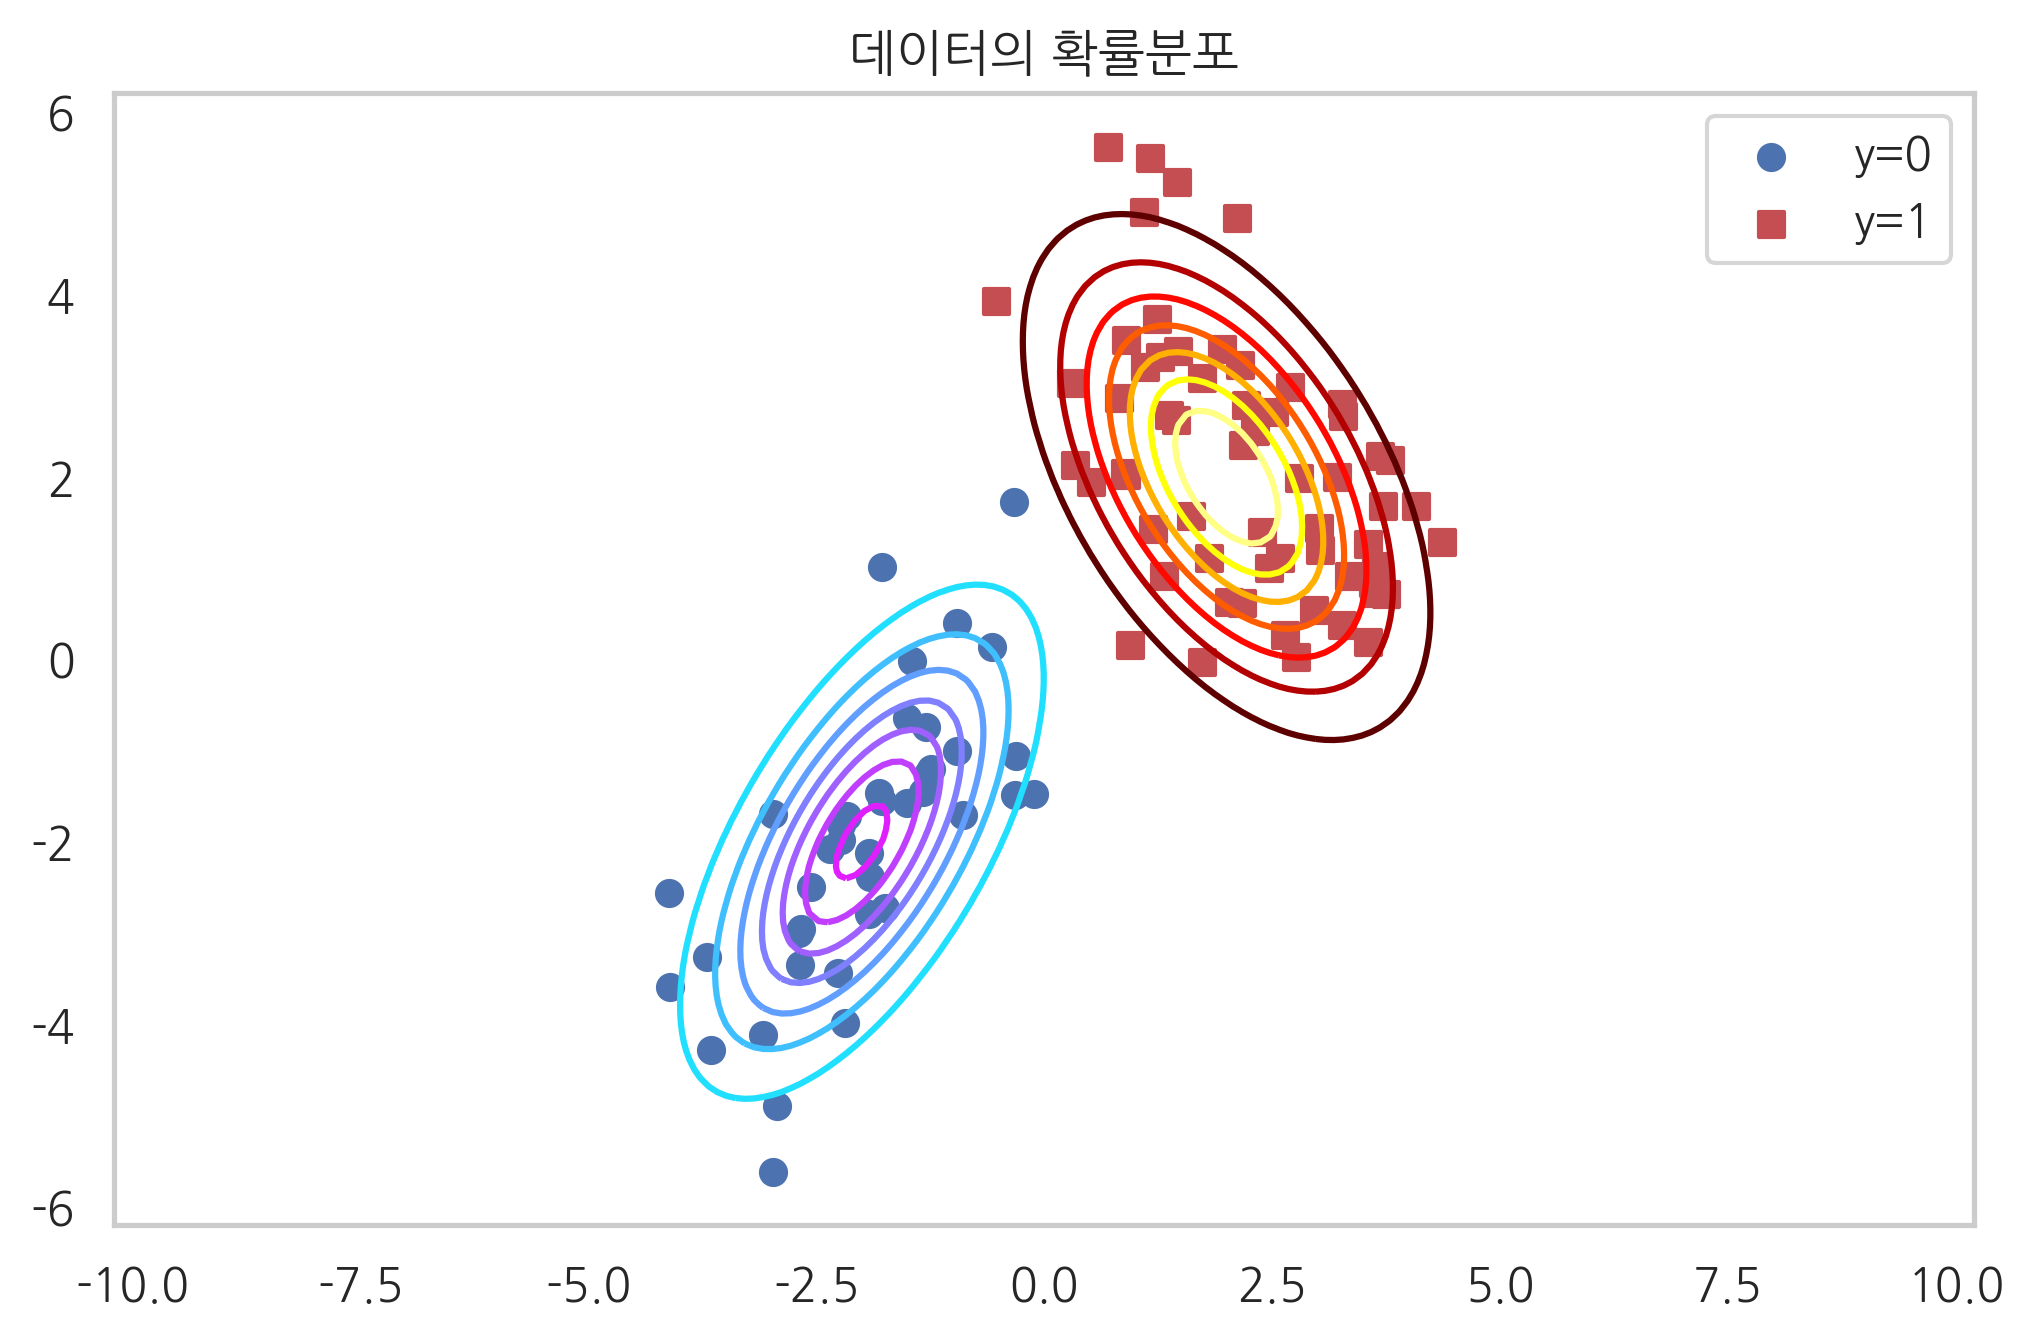

In [3]:
np.random.seed(0)
rv0 = sp.stats.multivariate_normal([-2, -2], [[1, 0.9], [0.9, 2]])
rv1 = sp.stats.multivariate_normal([2, 2], [[1.2, -0.8], [-0.8, 2]])
X0 = rv0.rvs(40)
X1 = rv1.rvs(60)
X = np.vstack([X0, X1])
y = np.hstack([np.zeros(40), np.ones(60)])

xx1 = np.linspace(-5, 5, 100)
xx2 = np.linspace(-5, 5, 100)
XX1, XX2 = np.meshgrid(xx1, xx2)
plt.grid(False)
plt.contour(XX1, XX2, rv0.pdf(np.dstack([XX1, XX2])), cmap=mpl.cm.cool)
plt.contour(XX1, XX2, rv1.pdf(np.dstack([XX1, XX2])), cmap=mpl.cm.hot)
plt.scatter(X0[:, 0], X0[:, 1], marker="o", c='b', label="y=0")
plt.scatter(X1[:, 0], X1[:, 1], marker="s", c='r', label="y=1")
plt.legend()
plt.title("데이터의 확률분포")
plt.axis("equal")
plt.show()

이 데이터를 가우시안 나이브베이즈 모형으로 다음처럼 풀 수 있다.

In [4]:
from sklearn.naive_bayes import GaussianNB
model_norm = GaussianNB().fit(X, y)

y 클래스의 종류와 각 클래스에 속하는 표본의 수, 그리고 그 값으로부터 구한 사전 확률

$$ p(y=0), p(y=1) $$

의 값은 다음과 같다.

In [5]:
model_norm.classes_

array([0., 1.])

In [6]:
model_norm.class_count_

array([40., 60.])

In [7]:
model_norm.class_prior_

array([0.4, 0.6])

각 클래스에 따라 $x$가 이루는 확률분포의 모수를 계산하면 다음과 같다. 나이브 가정에 따라 $x_1, x_2$는 독립이므로 상관관계를 구하지 않았다. 

In [8]:
model_norm.theta_[0], model_norm.sigma_[0]

(array([-1.96197643, -2.00597903]), array([1.02398854, 2.31390497]))

In [9]:
model_norm.theta_[1], model_norm.sigma_[1]

(array([2.19130701, 2.12626716]), array([1.25429371, 1.93742544]))

이렇게 구한 데이터의 확률분포를 시각화하면 다음과 같다.

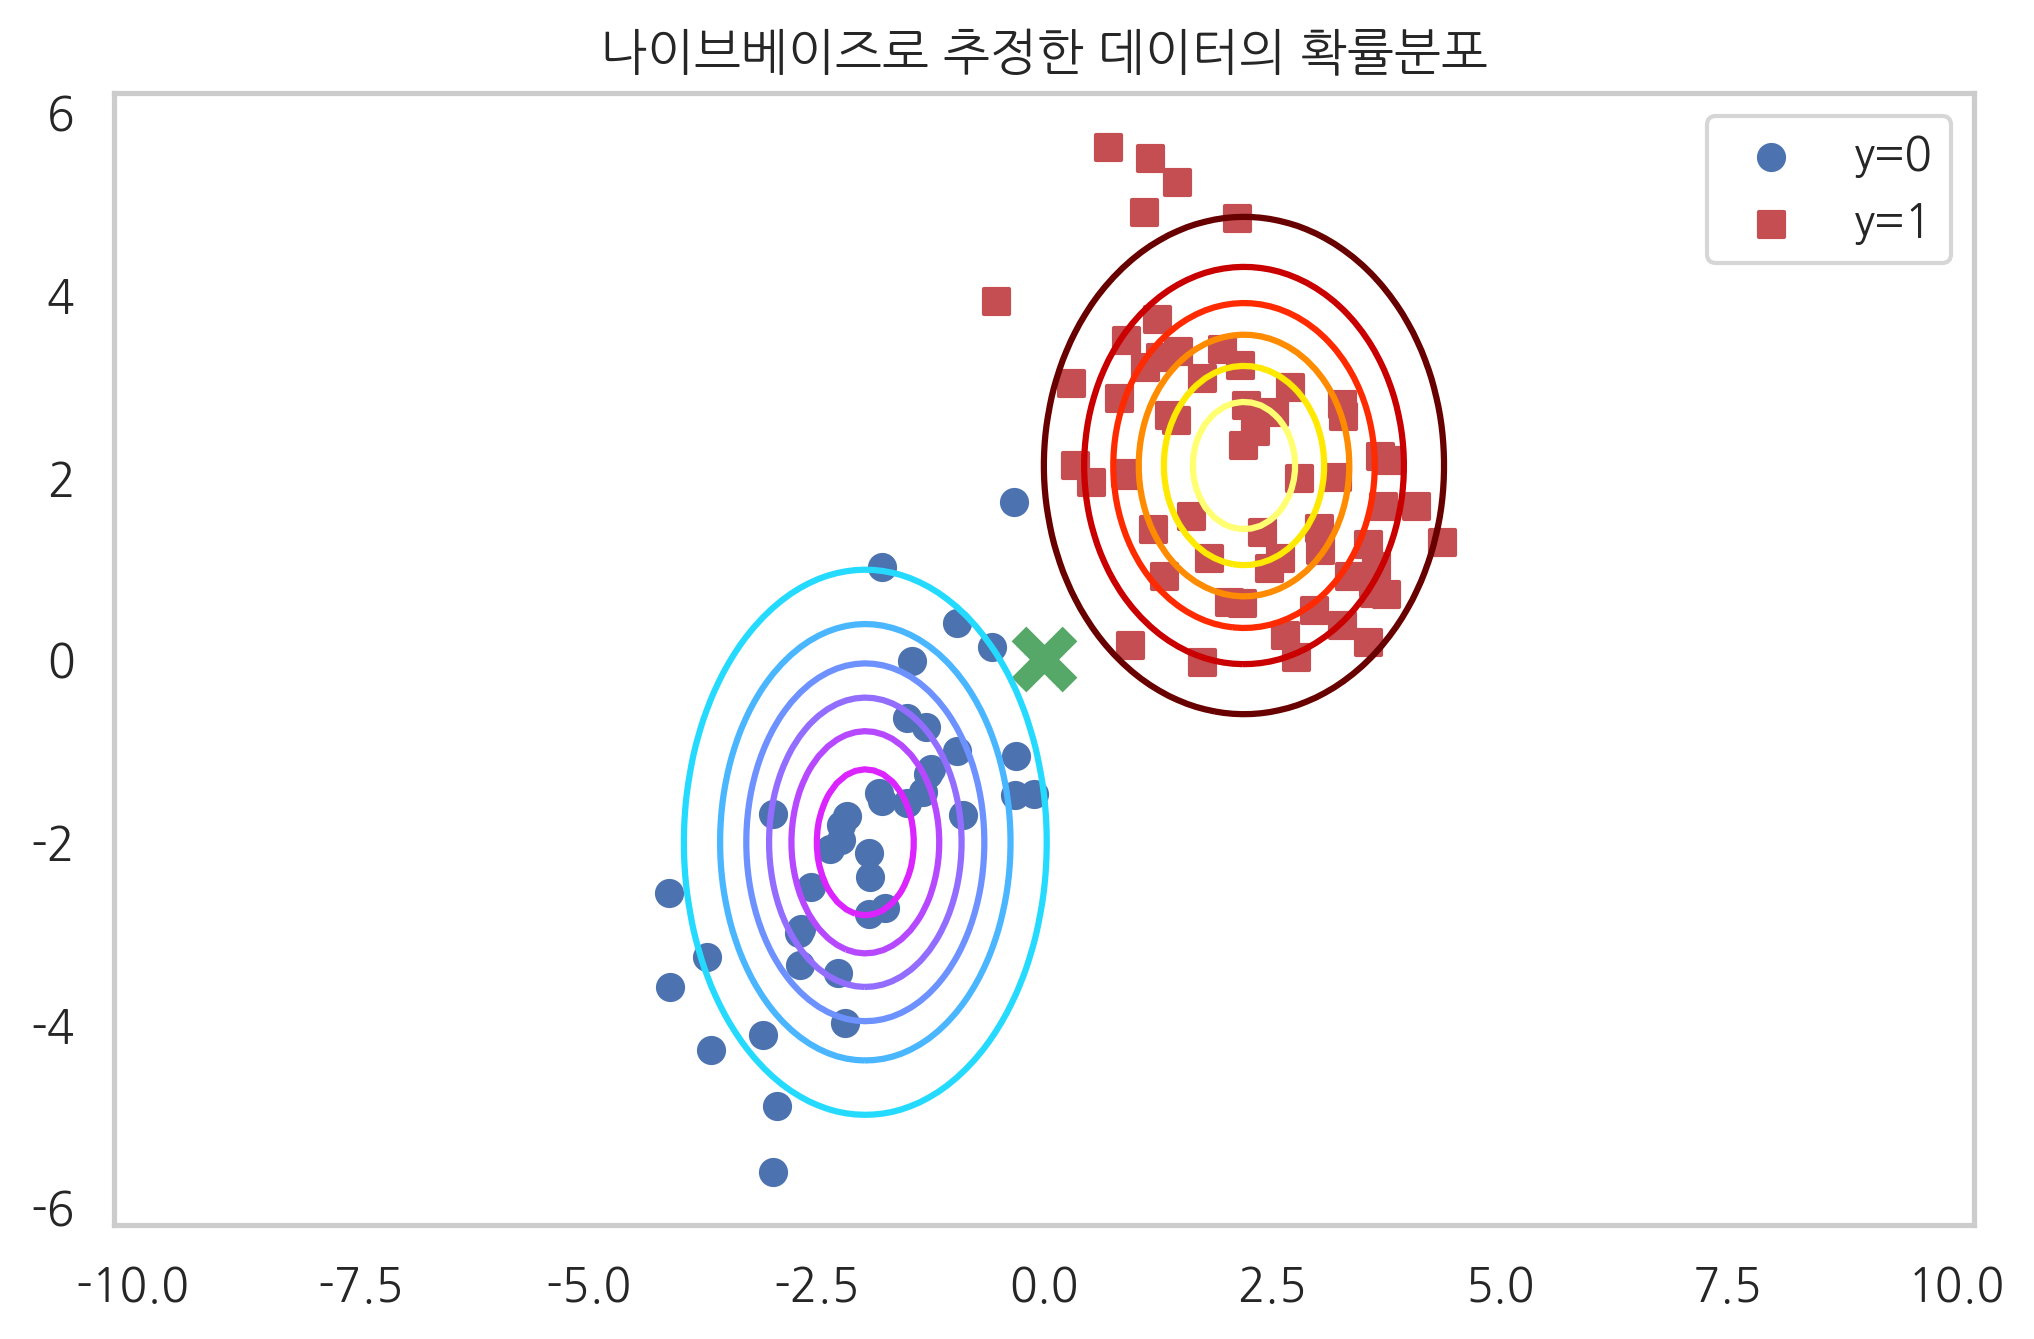

In [10]:
rv0 = sp.stats.multivariate_normal(model_norm.theta_[0], model_norm.sigma_[0])
rv1 = sp.stats.multivariate_normal(model_norm.theta_[1], model_norm.sigma_[1])

xx1 = np.linspace(-5, 5, 100)
xx2 = np.linspace(-5, 5, 100)
XX1, XX2 = np.meshgrid(xx1, xx2)
plt.grid(False)
plt.contour(XX1, XX2, rv0.pdf(np.dstack([XX1, XX2])), cmap=mpl.cm.cool)
plt.contour(XX1, XX2, rv1.pdf(np.dstack([XX1, XX2])), cmap=mpl.cm.hot)
plt.scatter(X0[:, 0], X0[:, 1], marker="o", c='b', label="y=0")
plt.scatter(X1[:, 0], X1[:, 1], marker="s", c='r', label="y=1")

x_new = [0, 0]
plt.scatter(x_new[0], x_new[1], c="g", marker="x", s=150, linewidth=5)
plt.legend()
plt.title("나이브베이즈로 추정한 데이터의 확률분포")
plt.axis("equal")
plt.show()

In [26]:
# 조건부 독립을 가정해 서로 상관관계가 없다고 가정을 했기 때문에 서로 방향성 없이 직각 형태로 나온다

이 모형을 사용하여 $x_{\text{new}} = (0, 0)$인 데이터의 $y$값을 예측하자. 각 클래스값이 나올 확률은 `predict_proba` 메서드로 구할 수 있다. 결과는 y=0일 확률이 0.48, y=1일 확률이 0.52이다.

In [11]:
model_norm.predict_proba([x_new])

array([[0.48475244, 0.51524756]])

이 값이 나오게 된 중간 과정을 살펴보자. 우선 추정된 독립변수의 모수와 정규 분포의 확률 밀도 함수를 사용하여 가능도를 구할 수 있다.
나이브베이즈 가정에 따라 두 입력 변수의 곱을 결합 확률로 계산한다.

$$ p(x_1, x_2 | y) \propto p(x_1| y) p(x_2| y) $$

In [12]:
likelihood = [
    (sp.stats.norm(model_norm.theta_[0][0], np.sqrt(model_norm.sigma_[0][0])).pdf(x_new[0]) * \
     sp.stats.norm(model_norm.theta_[0][1], np.sqrt(model_norm.sigma_[0][1])).pdf(x_new[1])),
    (sp.stats.norm(model_norm.theta_[1][0], np.sqrt(model_norm.sigma_[1][0])).pdf(x_new[0]) * \
     sp.stats.norm(model_norm.theta_[1][1], np.sqrt(model_norm.sigma_[1][1])).pdf(x_new[1])),
]
likelihood

[0.006615760017637298, 0.00468796559514829]

여기에 사전 확률을 곱하면 사후 확률에 비례하는 값이 나온다.

$$ p(y|x_1, x_2) \propto p(x_1, x_2|y) p(y) $$

아직 정규화 상수 $p(x)$로 나누어주지 않았으므로 두 값의 합이 1이 아니다. 즉, 확률이라고 부를 수는 없다. 하지만 크기를 비교하면 y=0일 확률이 y=1일 확률보다 훨씬 크다는 것을 알 수 있다.

In [13]:
posterior = likelihood * model_norm.class_prior_
posterior

array([0.0026463 , 0.00281278])

In [29]:
# 사실 확률이 아니다, 정규화 상수라고 하는 분모가 빠져 있기 때문. 둘 중에 뭐가 큰지 보면 된다
# 정 확률을 구하고 싶으면 전체 확률의 법칙(두 개를 더해서 나눠준다) 쓰면 된다
# 근데 굳이 여기선 구할 필요 없으므로 값이 더 큰 클래스1이 답이 되는 것

이 값을 정규화하면 `predict_proba` 메서드로 구한 것과 같은 값이 나온다.

In [14]:
posterior / posterior.sum()

array([0.48475244, 0.51524756])

#### 연습 문제 1

붓꽃 분류문제를 가우시안 나이브베이즈 모형을 사용하여 풀어보자.

(1) 각각의 종이 선택될 사전확률을 구하라.

(2) 각각의 종에 대해 꽃받침의 길이, 꽃받침의 폭, 꽃잎의 길이, 꽃잎의 폭의 평균과 분산을 구하라.

(3) 학습용 데이터를 사용하여 분류문제를 풀고 다음을 계산하라.

* 분류결과표
* 분류보고서

In [34]:
# 살제로는 꽃받침의 폭과 길이가 서로 독립이 아니다. 서로 상관관계가 있다
# 맞지 않는 가정이다. 그레서 이름이 naive(순진한, 실제로는 안 맞을 것 같다) 가정이다.
# 위 연습문제는 일일이 다 구할 필요 없이 피팅하면 그 값이 다 속성으로 들어 있음
# 엄청나게 단순화 했는데도 QDA,LDA의 정확도 결과값과 거의 차이가 없다

### 베르누이분포 나이브베이즈 모형

전자우편과 같은 문서 내에 특정한 단어가 포함되어 있는지의 여부는 베르누이 확률변수로 모형화할 수 있다. 이렇게 독립변수가 0 또는 1의 값을 가지면 베르누이 나이브베이즈 모형을 사용한다. 

베르누이분포 나이브베이즈 모형 클래스 `BernoulliNB`는 가능도 추정과 관련하여 다음 속성을 가진다.

* `feature_count_`: 각 클래스 $k$에 대해 $d$번째 동전이 앞면이 나온 횟수 $N_{d,k}$
* `feature_log_prob_`: 베르누이분포 모수의 로그
 
$$ \log \mu_k = (\log \mu_{1,k}, \ldots, \log \mu_{D, k}) = \left( \log \dfrac{N_{1,k}}{N_k}, \ldots, \log \dfrac{N_{D,k}}{N_k} \right)$$
 
여기에서 $N_k$은 클래스 $k$에 대해 동전을 던진 총 횟수이다. 
표본 데이터의 수가 적은 경우에는 모수에 대해 다음처럼 스무딩(smoothing)을 할 수도 있다.

In [39]:
# log 취하는 이유는 부동소수점 문제 등....

### 스무딩

In [42]:
# 베르누이 분포에서 동전 10번 던져서 앞면이 한 번도 안 나올 확률, 10번 다 앞면이 나올 확률은 너무 극단적
# 얘를 고치자, 마사지를 하자 하는 게 공식적 용어로 스무딩
# 데이터를 섞어버리자는 것. 원래 있지도 않은 가짜데이터를 섞어서 데이터 마사지 하자는 것
# 확률 아무것도 모른다고 할 때 나오는 0.5랑 섞어보자는 것
# 비현실적인 경우다라는 우리의 도메인 지식을 활용한 사례

표본 데이터의 수가 적은 경우에는 베르누이 모수가 0 또는 1이라는 극단적인 모수 추정값이 나올 수도 있다. 하지만 현실적으로는 실제 모수값이 이런 극단적인 값이 나올 가능성이 적다. 따라서 베르누이 모수가 0.5인 가장 일반적인 경우를 가정하여 0이 나오는 경우와 1이 나오는 경우, 두 개의 가상 표본 데이터를 추가한다. 그러면 0이나 1과 같은 극단적인 추정값이 0.5에 가까운 다음과 값으로 변한다. 이를 라플라스 스무딩(Laplace smoothing) 또는 애드원(Add-One) 스무딩이라고 한다.

$$ \hat{\mu}_{d,k} = \frac{ N_{d,k} + \alpha}{N_k + 2 \alpha} $$ 

가중치 $\alpha$를 사용하여 스무딩의 정도를 조절할 수도 있다. 가중치 $\alpha$는 정수가 아니라도 괜찮다. 가중치가 1인 경우는 무정보 사전확률을 사용한 베이즈 모수추정의 결과와 같다.

In [43]:
# 알파 값을 점점 크게 하면 mu hat 값은 1/2로 수렴한다
# 알파를 보통 1 정도만 놓는다
# 이를 라플라스 스무딩, 애드원 스무딩(가짜 데이터를 한 세트 섞었다는 말) 

In [15]:
X = np.array([
    [0, 1, 1, 0],
    [1, 1, 1, 1],
    [1, 1, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 1, 1, 0],
    [0, 1, 1, 1],
    [1, 0, 1, 0],
    [1, 0, 1, 1],
    [0, 1, 1, 0]])
y = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

이 데이터는 4개의 키워드를 사용하여 정상 메일 4개와 스팸 메일 6개를 BOW 인코딩한 행렬이다. 예를 들어 첫번째 메일은 정상 메일이고 1번, 4번 키워드는 포함하지 않지만 2번, 3번 키워드를 포함한다고 볼 수 있다.

이 데이터를 베르누이 나이브베이즈 모형으로 예측해 보자.

In [16]:
from sklearn.naive_bayes import BernoulliNB
model_bern = BernoulliNB().fit(X, y)

y 클래스의 종류와 각 클래스에 속하는 표본의 수, 그리고 그 값으로부터 구한 사전 확률의 값은 다음과 같다.

In [17]:
model_bern.classes_

array([0, 1])

In [18]:
model_bern.class_count_

array([4., 6.])

In [19]:
np.exp(model_bern.class_log_prior_)

array([0.4, 0.6])

각 클래스 $k$ 별로, 그리고 각 독립변수 $d$ 별로, 각각 다른 베르누이 확률변수라고 가정하여 모두 8개의 베르누이 확률변수의 모수를 구하면 다음과 같다.

In [20]:
fc = model_bern.feature_count_
fc

array([[2., 4., 3., 1.],
       [2., 3., 5., 3.]])

In [21]:
fc / np.repeat(model_bern.class_count_[:, np.newaxis], 4, axis=1)

array([[0.5       , 1.        , 0.75      , 0.25      ],
       [0.33333333, 0.5       , 0.83333333, 0.5       ]])

그런데 이 값은 모형 내에서 구한 값과 다르다. 모형 내에서 스무딩(smoothing)이 이루어지기 때문이다. 스무딩은 동전의 각 면 즉, 0과 1이 나오는 가상의 데이터를 추가함으로서 추정한 모수의 값이 좀 더 0.5에 가까워지도록 하는 방법이다. 이 때 사용한 스무딩 가중치 값은 다음처럼 확인할 수 있다.

In [22]:
model_bern.alpha

1.0

스무딩이 적용된 베르누이 모수값은 다음과 같다.

In [23]:
theta = np.exp(model_bern.feature_log_prob_)
theta

array([[0.5       , 0.83333333, 0.66666667, 0.33333333],
       [0.375     , 0.5       , 0.75      , 0.5       ]])

이에 모형이 완성되었으니 테스트 데이터를 사용하여 예측을 해 본다. 예를 들어 1번, 2번 키워드를 포함한 메일이 정상 메일인지 스팸 메일인지 알아보자.

In [24]:
x_new = np.array([0, 1, 1, 1])

In [25]:
model_bern.predict_proba([x_new])

array([[0.34501348, 0.65498652]])

위 결과에서 정상 메일일 가능성이 약 3배임을 알 수 있다. 이 값은 다음처럼 구할 수도 있다.

In [26]:
p = ((theta ** x_new) * (1 - theta) ** (1 - x_new)).prod(axis=1)\
    * np.exp(model_bern.class_log_prior_)
p / p.sum()

array([0.34501348, 0.65498652])

반대로 3번, 4번 키워드가 포함된 메일은 스팸일 가능성이 약 90%이다.

In [27]:
x_new = np.array([0, 0, 1, 1])

In [28]:
model_bern.predict_proba([x_new])

array([[0.09530901, 0.90469099]])

In [29]:
p = ((theta ** x_new) * (1 - theta) ** (1 - x_new)).prod(axis=1)\
    * np.exp(model_bern.class_log_prior_)
p / p.sum()

array([0.09530901, 0.90469099])

#### 연습 문제 2

(1) MNIST 숫자 분류문제에서 `sklearn.preprocessing.Binarizer`로 x값을 0, 1로 바꾼다(값이 8 이상이면 1, 8 미만이면 0). 즉 흰색과 검은색 픽셀로만 구성된 이미지로 만든다(다음 코드 참조)
```
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target
from sklearn.preprocessing import Binarizer
X = Binarizer(7).fit_transform(X)
```

이 이미지에 대해 베르누이 나이브베이즈 모형을 적용하자. 분류 결과를 분류보고서 형식으로 나타내라.

(2) `BernoulliNB` 클래스의 `binarize` 인수를 사용하여 같은 문제를 풀어본다.

(3) 계산된 모형의 모수 벡터 값을 각 클래스별로 8x8 이미지의 형태로 나타내라. 이 이미지는 무엇을 뜻하는가?


In [1]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target
#y.shape

In [2]:
X
#X.shape (1797, 64)


array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [198]:
print(X.shape)
print(digits.images.shape)

(1797, 64)
(1797, 8, 8)


In [189]:
digits.images[0, :, :].shape

(8, 8)

In [3]:
from sklearn.preprocessing import Binarizer
X = Binarizer(7).fit_transform(X)
X2 = X[0].reshape(8,8)
X2.shape

(8, 8)

(-0.5, 7.5, 7.5, -0.5)

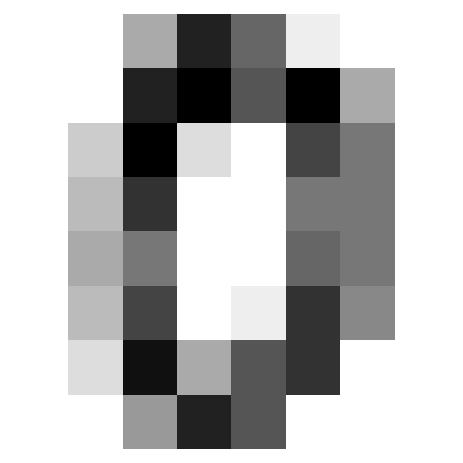

In [4]:
plt.imshow(digits.images[0, :, :], cmap = plt.cm.binary)
plt.axis("off")

(-0.5, 7.5, 7.5, -0.5)

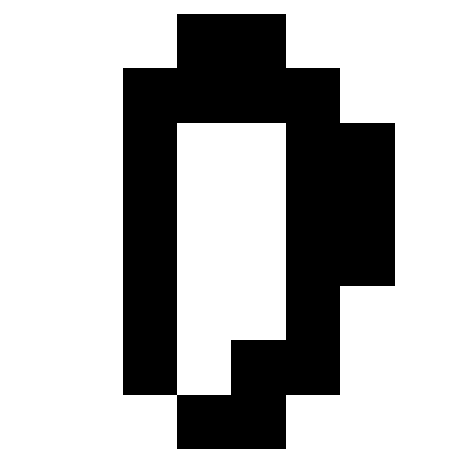

In [5]:
plt.imshow(X2, cmap = plt.cm.binary)
plt.axis("off")

In [ ]:
from sklearn.naive_bayes import BernoulliNB
model_bern = BernoulliNB.fit(X, y)